# 3for2 IAQ Data from BMS

Clayton Miller
Feb 22, 2017

Extract data and analyze data according to Jovan's instructions:

```
Let's start small with one diagram that you will show me for example temperature ( a spread of temperature during occupied and unoccupied hours during a given period of time) and email below is the mapping of what would be great to have. When we figure out one diagram let's move forward. Things below are a comparison of conditions close to the occupant (occupant height 1.1 - 1.5 m) and room readings. I want to see how they match. I actually went through the data myself and some match and some don't so I will use that as an important parameter in the analysis.

This will be 2nd data set we will compare and there will be one more to come.

from 29th December till 7th January compare readings for Operative temperature (Ball temperature) of IAQ devices and air temperature readings of room sensors. The same should be done with CO2 readings. Mapping is given below. I will only map temperature and it will be clear what to do with CO2. Instead of last letter T will be AQualR.

Photon 2 to B10_Area3for2_R_O_Sen_1_TR
        B10_Area3for2_R_O_Sen_2_TR
        B10_Area3for2_R_O_Sen_3_TR
        B10_Area3for2_R_O_Sen_4_TR
        B10_Area3for2_R_O_Sen_5_TR
        B10_Area3for2_R_O_Sen_6_TR
        B10_Area3for2_R_O_Sen_7_TR

Photon 3 to B10_Area3for2_R_FO3_Sen_1_TR
                    B10_Area3for2_R_FO3_Sen_2_TR
                    B10_Area3for2_R_FO3_Sen_3_TR

Photon 5 to B10_Area3for2_R_P_Sen_1_TR
                   B10_Area3for2_R_P_Sen_2_TR
                   B10_Area3for2_R_P_Sen_3_TR
                   B10_Area3for2_R_P_Sen_4_TR
                   B10_Area3for2_R_P_Sen_5_TR

From 10th February till 16th February comparison of Operative Temperature (Ball Temperature) and room readings for CO2 and temperature.

Photon 1 to B10_Area3for2_R_HRM_Sen_1_TR
                    B10_Area3for2_R_HRM_Sen_2_TR
                    B10_Area3for2_R_HRM_Sen_3_TR

Photon 2 to B10_Area3for2_R_O_Sen_1_TR
        B10_Area3for2_R_O_Sen_2_TR
        B10_Area3for2_R_O_Sen_3_TR
        B10_Area3for2_R_O_Sen_4_TR
        B10_Area3for2_R_O_Sen_5_TR
        B10_Area3for2_R_O_Sen_6_TR
        B10_Area3for2_R_O_Sen_7_TR

Photon 3 to B10_Area3for2_R_FO3_Sen_1_TR
                    B10_Area3for2_R_FO3_Sen_2_TR
                    B10_Area3for2_R_FO3_Sen_3_TR

Photon 4 to B10_Area3for2_R_P_Sen_1_TR
                   B10_Area3for2_R_P_Sen_2_TR
                   B10_Area3for2_R_P_Sen_3_TR
                   B10_Area3for2_R_P_Sen_4_TR
                   B10_Area3for2_R_P_Sen_5_TR
```

In [120]:
%matplotlib inline

In [138]:
import pandas as pd
from influxdb import DataFrameClient
import pytz
import seaborn as sns
import json
import datetime
import matplotlib.pyplot as plt

from pylab import *
from __future__ import division

## First let's grab the BMS data

In [121]:
# host='horsebrokedown-clocktower-1.c.influxdb.com' 
# port='8086'
# login='influxdb'
# pw='a873671b790d4523'
# dbname = 'siemenstest'

host='lonepine-76a67992.influxcloud.net'
port='8086' 
login='loaddata'
pw='uwcsearocks88'
database = 'bms'

client = DataFrameClient(host, port, login, pw, database, ssl=True, verify_ssl=True)

In [122]:
seriesname = pd.DataFrame(list(client.query('SHOW SERIES'))[0])

In [123]:
series = seriesname['key'].str.split(",").apply(pd.Series)

In [124]:
series.head()

,0,1,2,3,4
0,bmspoint,DeviceNum=0,Location=DOAS1,System=Ventilation,Type=CO2
1,bmspoint,DeviceNum=0,Location=DOAS2,System=Ventilation,Type=CO2
2,bmspoint,DeviceNum=0,Location=DOAS3,System=Ventilation,Type=CO2
3,bmspoint,DeviceNum=0,Location=DOAS4,System=Ventilation,Type=CO2
4,bmspoint,DeviceNum=0,Location=FCU1,System=Ventilation,Type=CO2


In [125]:
series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 741 entries, 0 to 740
Data columns (total 5 columns):
0    741 non-null object
1    741 non-null object
2    741 non-null object
3    741 non-null object
4    741 non-null object
dtypes: object(5)
memory usage: 29.0+ KB


In [126]:
pointlist = list(series[0])

In [127]:
#client.query('SELECT * FROM bmspoint WHERE time > now() - 10d AND time < now() - 9d', chunked=True)

## Get all data from dates of Dec 29 - Jan 7

Dec 29 is 63 days ago -- we can pull out data 3 days at a time for the time range

In [358]:
dec_jan_timeranges = [(63,61),(61,59),(59,57),(57,55),(55,53)]
feb_timeranges = [(21,19),(19,17),(17,15),(15,13)]
febmar_timeranges = [(12,10),(10,8),(8,6),(6,5),(5,4),(4,3),(3,2),(2,1),(1,0)]

In [359]:
def get_data(begin, end, pointtype):
    data = client.query('SELECT * FROM bmspoint WHERE time > now() - '+str(end)+'d AND time < now() - '+str(begin)+'d')
    data = pd.DataFrame(data['bmspoint'])
    tz_pytz = pytz.timezone('Asia/Singapore')
    data = data.tz_convert(tz_pytz)
    df = data[(data.Type==pointtype)]
    df = pd.pivot_table(df, columns=["Location","DeviceNum"], index=df.index, values="value")
    df = df.resample('5min').mean()
    return df

## Get CO2

In [360]:
all_data_co2_febmar = pd.DataFrame()
for timerange in febmar_timeranges:
    print "timerange"+str(timerange)
    df = get_data(timerange[1],timerange[0],'CO2')
    all_data_co2_febmar = pd.concat([all_data_co2_febmar, df], axis=0)
all_data_co2_febmar.to_csv("./extracted_data/new_space/bulk_data/CO2_Feb20_Mar2_2017.csv")

timerange(12, 10)
timerange(10, 8)
timerange(8, 6)
timerange(6, 5)
timerange(5, 4)
timerange(4, 3)
timerange(3, 2)
timerange(2, 1)
timerange(1, 0)


In [671]:
all_data_co2_febmar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3461 entries, 2017-02-18 16:30:00+08:00 to 2017-03-02 16:35:00+08:00
Data columns (total 57 columns):
(Block10, Num0)                  2049 non-null float64
(Block3, Num0)                   2049 non-null float64
(BoardRoom, Num0)                3457 non-null float64
(BoardRoom, Num1)                3457 non-null float64
(BoardRoom, Num2)                3457 non-null float64
(BoardRoom, Num3)                3457 non-null float64
(BoardRoom, Num4)                3457 non-null float64
(BoardRoom, Num5)                3457 non-null float64
(BoardRoom, Num6)                3457 non-null float64
(DOAS1, Num0)                    3457 non-null float64
(DOAS1, Num1)                    3457 non-null float64
(DOAS2, Num0)                    3457 non-null float64
(DOAS3, Num0)                    3457 non-null float64
(DOAS4, Num0)                    3457 non-null float64
(FCU1, Num0)                     3457 non-null float64
(FCU2, Num0)        

In [361]:
# all_data_co2_feb = pd.DataFrame()
# for timerange in feb_timeranges:
#     print "timerange"+str(timerange)
#     df = get_data(timerange[1],timerange[0],'CO2')
#     all_data_co2 = pd.concat([all_data_co2_feb, df], axis=0)
# all_data_co2.to_csv("CO2_Feb10_16_2017.csv")

In [362]:
#all_data_co2.resample('H').mean().plot(figsize=(10,30), subplots=True);

In [363]:
all_data_co2_febmar.head()

Location                  Block10 Block3   BoardRoom                          \
DeviceNum                    Num0   Num0        Num0        Num1        Num2   
2017-02-18 16:30:00+08:00     NaN    NaN  506.000000  596.000000  625.000000   
2017-02-18 16:35:00+08:00     NaN    NaN  506.333333  598.666667  622.333333   
2017-02-18 16:40:00+08:00     NaN    NaN  509.500000  600.500000  622.500000   
2017-02-18 16:45:00+08:00     NaN    NaN  506.333333  598.666667  620.000000   
2017-02-18 16:50:00+08:00     NaN    NaN  504.500000  593.000000  619.500000   

Location                                                              DOAS1  \
DeviceNum                        Num3   Num4        Num5   Num6        Num0   
2017-02-18 16:30:00+08:00  636.000000  485.0  572.000000  531.0  592.000000   
2017-02-18 16:35:00+08:00  632.333333  486.0  574.000000  530.0  590.933329   
2017-02-18 16:40:00+08:00  631.500000  489.5  570.500000  530.0  593.399994   
2017-02-18 16:45:00+08:00  628.333333  494.0  569.666667  526.0  591.933329   
2017-02-18 16:50:00+08:00  629.500000  493.0  568.500000  525.5  591.899994   

Location                   ...   OpenOffice                                 \
DeviceNum                  ...         Num2        Num3        Num4   Num5   
2017-02-18 16:30:00+08:00  ...        631.0  520.000000  618.000000  556.0   
2017-02-18 16:35:00+08:00  ...        631.0  521.000000  619.333333  559.0   
2017-02-18 16:40:00+08:00  ...        626.5  519.500000  617.500000  554.0   
2017-02-18 16:45:00+08:00  ...        625.0  515.333333  616.000000  552.0   
2017-02-18 16:50:00+08:00  ...        627.0  518.500000  614.000000  551.0   

Location                                   Pantry                          \
DeviceNum                        Num6        Num0        Num1        Num2   
2017-02-18 16:30:00+08:00  547.000000  755.000000  530.000000  629.000000   
2017-02-18 16:35:00+08:00  542.666667  750.333333  533.333333  632.333333   
2017-02-18 16:40:00+08:00  546.500000  751.000000  533.000000  630.000000   
2017-02-18 16:45:00+08:00  547.666667  751.000000  532.000000  622.333333   
2017-02-18 16:50:00+08:00  543.500000  746.000000  527.500000  627.000000   

Location                                      
DeviceNum                        Num3   Num4  
2017-02-18 16:30:00+08:00  815.000000  516.0  
2017-02-18 16:35:00+08:00  817.000000  517.0  
2017-02-18 16:40:00+08:00  825.500000  517.0  
2017-02-18 16:45:00+08:00  818.666667  517.0  
2017-02-18 16:50:00+08:00  815.500000  516.0  

[5 rows x 57 columns]

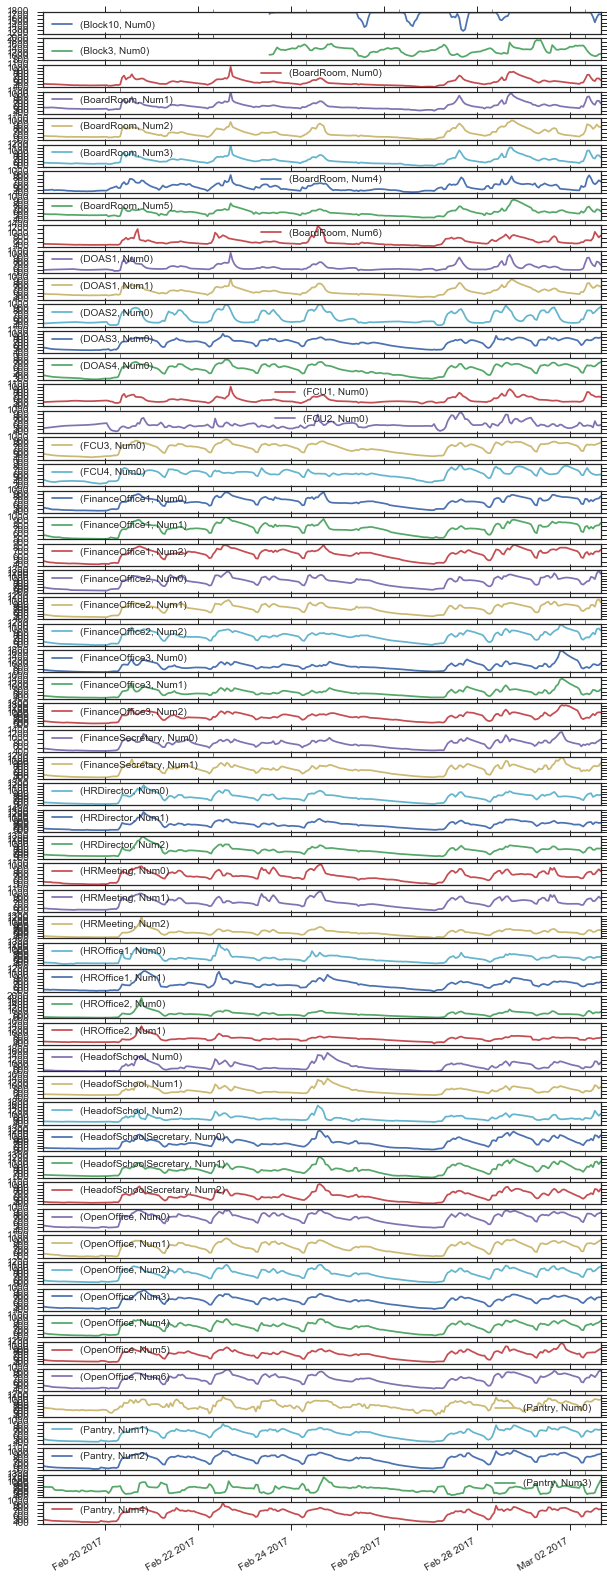

In [447]:
all_data_co2_febmar.resample('H').mean().plot(subplots=True, figsize=(10,30));

## Get BMS Air Temp

In [364]:
all_data_temp_febmar = pd.DataFrame()
for timerange in febmar_timeranges:
    print "timerange"+str(timerange)
    df = get_data(timerange[1],timerange[0],'AirTemp')
    all_data_temp_febmar = pd.concat([all_data_temp_febmar, df], axis=0)


timerange(12, 10)
timerange(10, 8)
timerange(8, 6)
timerange(6, 5)
timerange(5, 4)
timerange(4, 3)
timerange(3, 2)
timerange(2, 1)
timerange(1, 0)


In [681]:
#all_data_temp_febmar.tz_localize(None)

In [682]:
all_data_temp_febmar.tz_localize(None)#.head()
all_data_temp_febmar.to_csv("./extracted_data/new_space/bulk_data/Temp_Feb20_Mar2_2017.csv")

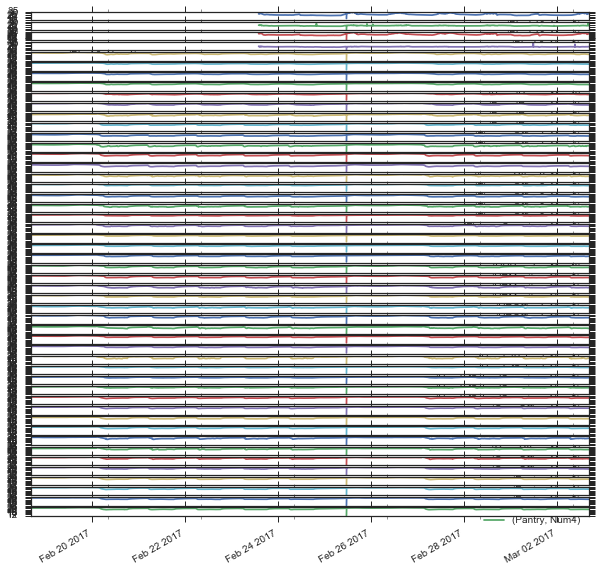

In [445]:
all_data_temp_febmar.plot(subplots=True, figsize=(10,10));

In [365]:
# all_data_temp_feb = pd.DataFrame()
# for timerange in feb_timeranges:
#     print "timerange"+str(timerange)
#     df = get_data(timerange[1],timerange[0],'AirTemp')
#     all_data_temp_feb = pd.concat([all_data_temp_feb, df], axis=0)
# all_data_temp_feb.to_csv("Temp_Feb10_16_2017.csv")

In [367]:
all_data_temp_febmar.head()

Location                  Block10      Block3       BoardRoom             \
DeviceNum                    Num0 Num1   Num0 Num1       Num0       Num1   
2017-02-18 16:35:00+08:00     NaN  NaN    NaN  NaN  24.939999  24.379999   
2017-02-18 16:40:00+08:00     NaN  NaN    NaN  NaN  24.959999  24.379999   
2017-02-18 16:45:00+08:00     NaN  NaN    NaN  NaN  24.953332  24.379999   
2017-02-18 16:50:00+08:00     NaN  NaN    NaN  NaN  24.969999  24.400000   
2017-02-18 16:55:00+08:00     NaN  NaN    NaN  NaN  24.966666  24.400000   

Location                                                               \
DeviceNum                       Num2       Num3       Num4       Num5   
2017-02-18 16:35:00+08:00  24.219999  24.240000  24.719999  24.429999   
2017-02-18 16:40:00+08:00  24.240000  24.250000  24.709999  24.410000   
2017-02-18 16:45:00+08:00  24.240000  24.246667  24.713332  24.420000   
2017-02-18 16:50:00+08:00  24.240000  24.240000  24.709999  24.420000   
2017-02-18 16:55:00+08:00  24.240000  24.253333  24.726666  24.420000   

Location                     ...     OpenOffice                        \
DeviceNum                    ...           Num2       Num3       Num4   
2017-02-18 16:35:00+08:00    ...      24.139999  24.879999  24.610000   
2017-02-18 16:40:00+08:00    ...      24.150000  24.879999  24.629999   
2017-02-18 16:45:00+08:00    ...      24.133333  24.873332  24.606667   
2017-02-18 16:50:00+08:00    ...      24.139999  24.879999  24.610000   
2017-02-18 16:55:00+08:00    ...      24.133333  24.866666  24.600000   

Location                                            Pantry             \
DeviceNum                       Num5       Num6       Num0       Num1   
2017-02-18 16:35:00+08:00  24.419999  24.619999  24.699999  24.789999   
2017-02-18 16:40:00+08:00  24.410000  24.610000  24.699999  24.770000   
2017-02-18 16:45:00+08:00  24.420000  24.606667  24.713332  24.779999   
2017-02-18 16:50:00+08:00  24.429999  24.610000  24.699999  24.759999   
2017-02-18 16:55:00+08:00  24.426666  24.613333  24.706666  24.786666   

Location                                                    
DeviceNum                       Num2       Num3       Num4  
2017-02-18 16:35:00+08:00  24.779999  24.709999  24.820000  
2017-02-18 16:40:00+08:00  24.799999  24.709999  24.820000  
2017-02-18 16:45:00+08:00  24.793332  24.699999  24.826667  
2017-02-18 16:50:00+08:00  24.779999  24.699999  24.830000  
2017-02-18 16:55:00+08:00  24.786666  24.706666  24.840000  

[5 rows x 50 columns]

## Get BMS Air Humidity

In [368]:
all_data_hum_febmar = pd.DataFrame()
for timerange in febmar_timeranges:
    print "timerange"+str(timerange)
    df = get_data(timerange[1],timerange[0],'RelativeHumidity')
    all_data_hum_febmar = pd.concat([all_data_hum_febmar, df], axis=0)
all_data_hum_febmar.to_csv("./extracted_data/new_space/bulk_data/Hum_Feb20_Mar2_2017.csv")

timerange(12, 10)
timerange(10, 8)
timerange(8, 6)
timerange(6, 5)
timerange(5, 4)
timerange(4, 3)
timerange(3, 2)
timerange(2, 1)
timerange(1, 0)


In [369]:
# all_data_hum_feb = pd.DataFrame()
# for timerange in feb_timeranges:
#     print "timerange"+str(timerange)
#     df = get_data(timerange[1],timerange[0],'RelativeHumidity')
#     all_data_hum_feb = pd.concat([all_data_hum_feb, df], axis=0)
# all_data_hum_feb.to_csv("Hum_Feb10_16_2017.csv")

In [370]:
all_data_hum_febmar.head()

Location                  Block10 Block3 BoardRoom                          \
DeviceNum                    Num0   Num0      Num0  Num1  Num2  Num3  Num4   
2017-02-18 16:40:00+08:00     NaN    NaN      83.0  82.0  83.0  79.0  80.0   
2017-02-18 16:45:00+08:00     NaN    NaN      83.0  82.0  83.0  79.0  80.0   
2017-02-18 16:50:00+08:00     NaN    NaN      83.0  82.0  83.0  79.0  80.0   
2017-02-18 16:55:00+08:00     NaN    NaN      83.0  82.0  83.0  79.0  80.0   
2017-02-18 17:00:00+08:00     NaN    NaN      83.5  82.0  84.0  79.0  80.0   

Location                        FinanceOffice1        ...  OpenOffice        \
DeviceNum                  Num5           Num0  Num1  ...        Num2  Num3   
2017-02-18 16:40:00+08:00  77.0           64.0  63.0  ...        73.0  69.0   
2017-02-18 16:45:00+08:00  77.0           64.0  63.0  ...        74.0  69.0   
2017-02-18 16:50:00+08:00  77.0           64.0  63.0  ...        74.0  69.0   
2017-02-18 16:55:00+08:00  77.0           64.0  63.0  ...        74.0  69.0   
2017-02-18 17:00:00+08:00  77.0           64.0  63.0  ...        74.0  69.0   

Location                                         Pantry                   \
DeviceNum                  Num4       Num5  Num6   Num0  Num1       Num2   
2017-02-18 16:40:00+08:00  65.0  69.000000  68.0   71.0  70.0  70.000000   
2017-02-18 16:45:00+08:00  66.0  68.000000  68.0   71.0  70.0  69.666667   
2017-02-18 16:50:00+08:00  66.0  69.000000  68.0   71.0  70.0  70.000000   
2017-02-18 16:55:00+08:00  66.0  68.333333  68.0   71.0  70.0  70.000000   
2017-02-18 17:00:00+08:00  66.0  69.000000  68.0   71.0  70.0  70.000000   

Location                               
DeviceNum                  Num3  Num4  
2017-02-18 16:40:00+08:00  71.0  70.0  
2017-02-18 16:45:00+08:00  71.0  70.0  
2017-02-18 16:50:00+08:00  71.0  70.0  
2017-02-18 16:55:00+08:00  71.0  70.0  
2017-02-18 17:00:00+08:00  71.0  70.0  

[5 rows x 47 columns]

## Get Particle Data

In [99]:
host='lonepine-76a67992.influxcloud.net'
port='8086' 
login='loaddata'
pw='uwcsearocks88'
database = 'particle'

client = DataFrameClient(host, port, login, pw, database, ssl=True, verify_ssl=True)

In [103]:
data = client.query('SELECT * FROM iaqsensor WHERE time > now() - 1000d')

In [106]:
data = pd.DataFrame(data['iaqsensor'])
tz_pytz = pytz.timezone('Asia/Singapore')
data = data.tz_convert(tz_pytz)

In [108]:
data.head()

,location,sensorbank,type,value
2016-08-02 10:26:27.558410155+08:00,None,Photon_5,Ball-Temp,23.651484
2016-08-02 10:26:30.474280270+08:00,None,Photon_5,Hum2,56.357670
2016-08-02 10:26:33.628612377+08:00,None,Photon_5,CO2ppm,664.000000
2016-08-02 10:26:36.618854281+08:00,None,Photon_5,Temp2,24.845121
2016-08-02 10:26:41.058726029+08:00,None,Photon_5,VOC-long,1000.000000


In [109]:
data = pd.pivot_table(data, index=data.index, columns=['type','sensorbank'], values='value')
data = data.resample("10min").mean()

In [110]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30530 entries, 2016-08-02 10:20:00+08:00 to 2017-03-02 10:30:00+08:00
Freq: 10T
Data columns (total 52 columns):
(Ball-Hum, Photon_1)       6703 non-null float64
(Ball-Hum, Photon_2)       3465 non-null float64
(Ball-Hum, Photon_3)       7421 non-null float64
(Ball-Hum, Photon_4)       4119 non-null float64
(Ball-Hum, Photon_5)       12204 non-null float64
(Ball-Temp, Photon_1)      6748 non-null float64
(Ball-Temp, Photon_2)      3542 non-null float64
(Ball-Temp, Photon_3)      7428 non-null float64
(Ball-Temp, Photon_4)      5192 non-null float64
(Ball-Temp, Photon_5)      12244 non-null float64
(Ball-Temp, TTest3)        3 non-null float64
(CO2-frmVOC, Photon_1)     6705 non-null float64
(CO2-frmVOC, Photon_2)     3535 non-null float64
(CO2-frmVOC, Photon_3)     7422 non-null float64
(CO2-frmVOC, Photon_4)     4293 non-null float64
(CO2-frmVOC, Photon_5)     12206 non-null float64
(CO2_11, CO2_1)            3 non-null float64
(CO2

In [111]:
data.to_csv("./extracted_data/new_space/bulk_data/ParticleData_All_2016_2017.csv")

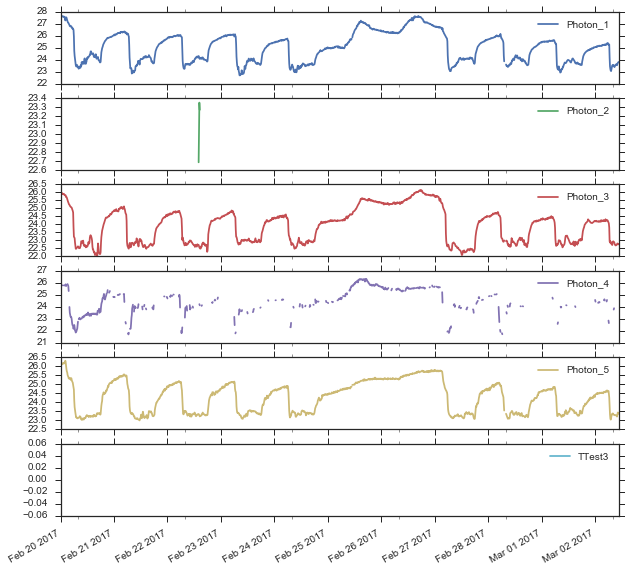

In [328]:
all_data_opptemp_febmar = data['Ball-Temp'].truncate(before='2017-02-20')
all_data_opptemp_febmar.plot(subplots=True, figsize=(10,10));

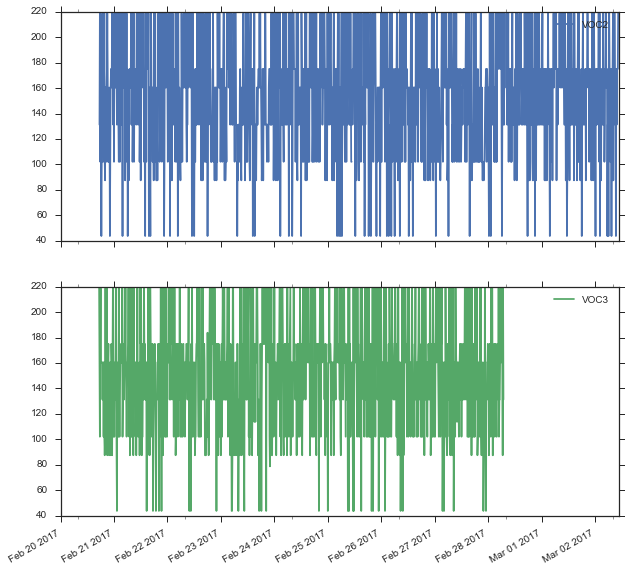

In [332]:
all_data_voc_febmar = data['VOC'].truncate(before='2017-02-20')
all_data_voc_febmar = all_data_voc_febmar[all_data_voc_febmar < 100].drop(["VOC1"], axis=1)
all_data_voc_febmar = all_data_voc_febmar*8.75
all_data_voc_febmar.plot(subplots=True, figsize=(10,10));

In [101]:
# allpoints = pd.DataFrame()
# for pointname in pointlist:
#     print "Getting "+pointname
#     try:
#         data = client.query('SELECT * FROM iaqpoint WHERE time > now() - 1000d')
#         data = pd.DataFrame(data[pointname])
#         tz_pytz = pytz.timezone('Asia/Singapore')
#         data = data.tz_convert(tz_pytz)
#         #data['pointname'] = data.sensorbank+"_"+data["type"]
#         #data = data.pivot(columns='pointname', values='value')
#         data = pd.pivot_table(data, index=data.index, columns=['type','sensorbank'], values='value')
#         data = data.resample("10min").mean()
#         allpoints = pd.concat([allpoints, data], axis=1)
#     #allpoints = pd.merge(allpoints, data, how='outer', right_index=True, left_index=True)
#     except:
#         print "Point not found"

# Create Visualizations
## Indoor Temperature

In [594]:
def pivot_day_2(df, cols, startdate, enddate, mapping):
    df_forpiv = df.truncate(before=startdate, after=enddate).resample('H').mean()
    
    df_forpiv = df_forpiv[df_forpiv.index.dayofweek < 5]
    #df_cooling_forpiv.columns = ["1","2","3","4"]

    df_forpiv['Date'] = df_forpiv.index.map(lambda t: t.date())
    df_forpiv['Time'] = df_forpiv.index.map(lambda t: t.time())

    df_pivot_1 = pd.pivot_table(df_forpiv, values=cols[0], index='Date', columns='Time')
    df_pivot_2 = pd.pivot_table(df_forpiv, values=cols[1], index='Date', columns='Time')
#     df_pivot_3 = pd.pivot_table(df_forpiv, values=cols[2], index='Date', columns='Time')
#     df_pivot_4 = pd.pivot_table(df_forpiv, values=cols[3], index='Date', columns='Time')

    df_pivot_sum = pd.DataFrame()
    df_pivot_sum[cols[0]] = df_pivot_1.mean()#.plot(figsize=(20,8))
    df_pivot_sum[cols[1]] = df_pivot_2.mean()#.plot()
#     df_pivot_sum[cols[2]] = df_pivot_3.mean()#.plot()
#     df_pivot_sum[cols[3]] = df_pivot_4.mean()#.plot()
    
    df_pivot_sum = df_pivot_sum.rename(columns=mapping)
    df_pivot_sum = df_pivot_sum.sort_index()
    
    return df_pivot_sum

In [595]:
def pivot_day(df, cols, startdate, enddate, mapping):
    df_forpiv = df.truncate(before=startdate, after=enddate).resample('H').mean()
    
    df_forpiv = df_forpiv[df_forpiv.index.dayofweek < 5]
    #df_cooling_forpiv.columns = ["1","2","3","4"]

    df_forpiv['Date'] = df_forpiv.index.map(lambda t: t.date())
    df_forpiv['Time'] = df_forpiv.index.map(lambda t: t.time())

    df_pivot_1 = pd.pivot_table(df_forpiv, values=cols[0], index='Date', columns='Time')
    df_pivot_2 = pd.pivot_table(df_forpiv, values=cols[1], index='Date', columns='Time')
    df_pivot_3 = pd.pivot_table(df_forpiv, values=cols[2], index='Date', columns='Time')
    df_pivot_4 = pd.pivot_table(df_forpiv, values=cols[3], index='Date', columns='Time')

    df_pivot_sum = pd.DataFrame()
    df_pivot_sum[cols[0]] = df_pivot_1.mean()#.plot(figsize=(20,8))
    df_pivot_sum[cols[1]] = df_pivot_2.mean()#.plot()
    df_pivot_sum[cols[2]] = df_pivot_3.mean()#.plot()
    df_pivot_sum[cols[3]] = df_pivot_4.mean()#.plot()
    
    df_pivot_sum = df_pivot_sum.rename(columns=mapping)
    df_pivot_sum = df_pivot_sum.sort_index()
    
    return df_pivot_sum

In [596]:
def get_occ_and_unoocdata(pointdata, excludedcol, startdate, enddate):
    pointdata = pointdata.truncate(before=startdate, after=enddate)#.resample('H').mean()
    if excludedcol != "none":
        pointdata = pointdata.drop(excludedcol, axis=1)
    #exclude weekend
    pointdata_weekday = pointdata[pointdata.index.dayofweek < 5]
    
    #get occupied
    pointdata_weekday_occupied = pointdata_weekday.ix[pointdata_weekday.index.indexer_between_time(datetime.time(9), datetime.time(17))] 
    
    #get unoccupied
    first = pointdata_weekday.ix[pointdata_weekday.index.indexer_between_time(datetime.time(0), datetime.time(6))]
    last = pointdata_weekday.ix[pointdata_weekday.index.indexer_between_time(datetime.time(21), datetime.time(23))]
    pointdata_weekday_unoccupied = pd.concat([first,last], axis=0).sort_index()
    
#     pointdata.plot(figsize=(15,6), title="All Data");
#     pointdata_weekday_occupied.plot(title="Occupied",figsize=(15,6));
#     pointdata_weekday_unoccupied.plot(title="Unoccupied",figsize=(15,6));

    return pointdata, pointdata_weekday_occupied, pointdata_weekday_unoccupied

In [597]:
# sns.set_style("whitegrid")
sns.set(style="ticks")

In [598]:
name_mapping = {"FinanceOffice3":"Finance Office", "HRMeeting":"HR Meeting", "OpenOffice":"Open Office", "HRDirector":"HR Director"}
particle_name_mapping = {"Photon_1":"HR Meeting", "Photon_3":"Finance Office", "Photon_4":"Open Office", "Photon_5":"HR Director"}
voc_name_mapping = {"VOC2":"HR Meeting","VOC3":"Open Office"}

In [599]:
temp_grouped = all_data_temp_febmar.groupby(level='Location', axis=1).mean()

In [600]:
temp_grouped.head()

Location,Block10,Block3,BoardRoom,FinanceOffice1,FinanceOffice2,FinanceOffice3,FinanceSecretary,HRDirector,HRMeeting,HROffice1,HROffice2,HeadofSchool,HeadofSchoolSecretary,OpenOffice,Pantry
2017-02-18 16:35:00+08:00,NaN,NaN,24.534285,25.083333,25.233333,24.963333,24.509999,24.256666,25.993333,25.195000,25.125000,24.753333,23.886666,24.472857,24.759999
2017-02-18 16:40:00+08:00,NaN,NaN,24.537142,25.090000,25.233332,24.970000,24.509999,24.263333,25.986666,25.200000,25.134999,24.759999,23.889999,24.472857,24.759999
2017-02-18 16:45:00+08:00,NaN,NaN,24.538095,25.091111,25.248888,24.975555,24.516666,24.260000,26.011110,25.216666,25.133333,24.757777,23.893333,24.467619,24.762666
2017-02-18 16:50:00+08:00,NaN,NaN,24.544285,25.096666,25.249999,24.973333,24.525000,24.263333,26.013333,25.214999,25.130000,24.769999,23.896666,24.474285,24.753999
2017-02-18 16:55:00+08:00,NaN,NaN,24.547619,25.102222,25.251111,24.971111,24.529999,24.277777,26.006666,25.219999,25.140000,24.768888,23.895555,24.468571,24.765333


In [601]:
df_pivot = pivot_day(temp_grouped, ['OpenOffice','FinanceOffice3','HRMeeting','HRDirector'], '2017-02-20','2017-03-02', name_mapping)

In [602]:
temp, temp_occupied, temp_unoccupied = get_occ_and_unoocdata(temp_grouped, [u'BoardRoom',u'FinanceOffice1',
 u'FinanceOffice2',
 #u'FinanceOffice3',
 u'FinanceSecretary',
 #u'HRDirector',
 #u'HRMeeting',
 u'HROffice1',
 u'HROffice2',
 u'HeadofSchool',
 u'HeadofSchoolSecretary',
 u'Pantry',"Block10","Block3"]
                                                            , '2017-02-20','2017-03-02')
 

In [603]:
temp_occupied.head()

Location,FinanceOffice3,HRDirector,HRMeeting,OpenOffice
2017-02-20 09:00:00+08:00,22.123333,22.443333,22.423333,22.287142
2017-02-20 09:05:00+08:00,22.142222,22.428888,22.393333,22.333333
2017-02-20 09:10:00+08:00,22.193333,22.410000,22.366666,22.335714
2017-02-20 09:15:00+08:00,22.260000,22.391111,22.360000,22.323809
2017-02-20 09:20:00+08:00,22.313333,22.356666,22.330000,22.341428


In [491]:
#name_mapping = {"FinanceOffice3":"Finance Office", "HRMeeting":"HR Meeting", "OpenOffice":"Open Office", "Pantry":"Pantry"}

In [672]:
def rename_and_melt(df, mapping, labelname):
    df = df.rename(columns=mapping)
    df = df.sort_index()
    df = pd.melt(df)
    df['Schedule'] = labelname
    return df 

def flatten_and_merge(occupied, unoccupied, mapping, unitname):
    occupied = rename_and_melt(occupied, mapping, labelname="Occupied")
    unoccupied = rename_and_melt(unoccupied, mapping, labelname="Unoccupied")
    total = pd.concat([occupied, unoccupied])
    total['unit'] = unitname
    total.columns = ["Zones", "Value", "Occupancy Type", "Unit"]
    #total.columns = ["Zones", unitname, "Occupancy Type"]
    return total

def plot_values(occupied, unoccupied, mapping, pointtype, colormap):
    df = flatten_and_merge(occupied, unoccupied, mapping, pointtype)
    sns.boxplot(x=df.Zones, y=df["Value"], hue=df["Occupancy Type"], palette=colormap)
    plt.ylabel(pointtype)

    return df

In [673]:
import matplotlib.ticker as ticker
import matplotlib.dates as mdates


In [674]:
def plot_values_all(df_occ, df_unocc, df_pivot, label1, label2, label3, mainlabel, name_mapping, colormap):
    fig1 = plt.figure(figsize=[12,4])
    fig1.suptitle(mainlabel, fontsize=14, y=1.03)
    gs = GridSpec(100,100,bottom=0.18,left=0.18,right=0.88)
    xfmt = ScalarFormatter()
    xfmt.set_powerlimits((-3,3))

    ax1 = fig1.add_subplot(gs[:,1:45])
    styles1 = ['s-','^-','<-','o-']
    df_pivot.plot(style=styles1, ax=ax1, xticks=arange(0, 86400, 14400))

    ax1.set_ylabel(label1)
    ax1.set_xlabel(label2)
#     myFmt = mdates.DateFormatter('%d')
#     ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter(myFmt))
    gca().yaxis.set_major_formatter(xfmt)

    ax2 = fig1.add_subplot(gs[:,55:100])
    df = plot_values(df_occ, df_unocc, name_mapping, label3, colormap)
    df.to_csv("./extracted_data/new_space/targeted_data/"+mainlabel+".csv")
    sns.despine(offset=10, trim=True)
    plt.savefig("./figures/NewSpace_"+mainlabel+".png", bbox_inches='tight')
    
    

In [683]:
temp_occupied.head()

Location,FinanceOffice3,HRDirector,HRMeeting,OpenOffice
2017-02-20 09:00:00+08:00,22.123333,22.443333,22.423333,22.287142
2017-02-20 09:05:00+08:00,22.142222,22.428888,22.393333,22.333333
2017-02-20 09:10:00+08:00,22.193333,22.410000,22.366666,22.335714
2017-02-20 09:15:00+08:00,22.260000,22.391111,22.360000,22.323809
2017-02-20 09:20:00+08:00,22.313333,22.356666,22.330000,22.341428


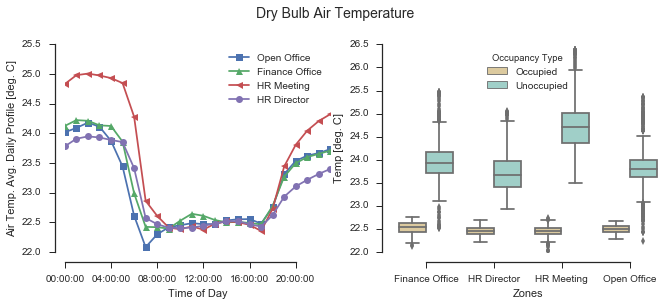

In [675]:
plot_values_all(temp_occupied, temp_unoccupied,df_pivot,"Air Temp. Avg. Daily Profile [deg. C]","Time of Day","Temp [deg. C]","Dry Bulb Air Temperature",name_mapping, "BrBG")

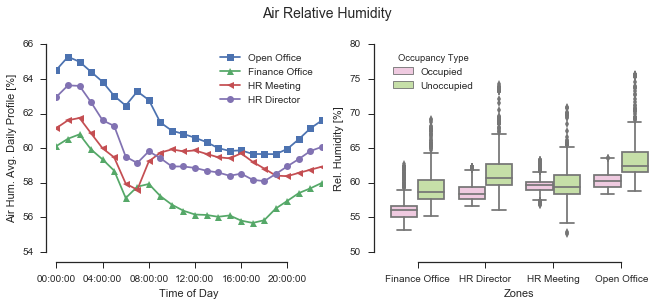

In [655]:
hum_grouped = all_data_hum_febmar.groupby(level='Location', axis=1).mean()
hum_pivot = pivot_day(hum_grouped, ['OpenOffice','FinanceOffice3','HRMeeting','HRDirector'], '2017-02-20','2017-03-02', name_mapping)
hum, hum_occupied, hum_unoccupied = get_occ_and_unoocdata(hum_grouped, [u'BoardRoom',u'FinanceOffice1',
 u'FinanceOffice2',
 #u'FinanceOffice3',
 u'FinanceSecretary',
 #u'HRDirector',
 #u'HRMeeting',
 u'HROffice1',
 u'HROffice2',
 u'HeadofSchool',
 u'HeadofSchoolSecretary',
 u'Pantry',"Block10","Block3"]
                                                            , '2017-02-20','2017-03-02')
plot_values_all(hum_occupied, hum_unoccupied, hum_pivot,"Air Hum. Avg. Daily Profile [%]","Time of Day","Rel. Humidity [%]","Air Relative Humidity", name_mapping, "PiYG")

In [609]:
co2_grouped.columns

Index([u'Block10', u'Block3', u'BoardRoom', u'DOAS1', u'DOAS2', u'DOAS3',
       u'DOAS4', u'FCU1', u'FCU2', u'FCU3', u'FCU4', u'FinanceOffice1',
       u'FinanceOffice2', u'FinanceOffice3', u'FinanceSecretary',
       u'HRDirector', u'HRMeeting', u'HROffice1', u'HROffice2',
       u'HeadofSchool', u'HeadofSchoolSecretary', u'OpenOffice', u'Pantry'],
      dtype='object', name=u'Location')

## Particle CO2

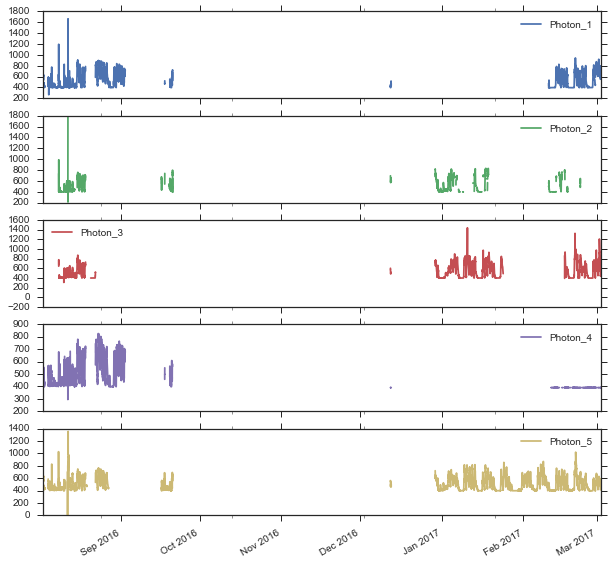

In [610]:
data['CO2ppm'][data['CO2ppm']<2000].plot(figsize=(10,10), subplots=True);

In [611]:
co2_part = data['CO2ppm'].truncate(before='2017-02-20')

In [612]:
co2_part.head()

sensorbank,Photon_1,Photon_2,Photon_3,Photon_4,Photon_5
2017-02-20 00:00:00+08:00,397.999941,NaN,398.0,390.0,412.867540
2017-02-20 00:10:00+08:00,397.999999,NaN,398.0,390.0,420.473953
2017-02-20 00:20:00+08:00,398.000000,NaN,398.0,390.0,409.677640
2017-02-20 00:30:00+08:00,398.000000,NaN,398.0,390.0,414.715569
2017-02-20 00:40:00+08:00,398.000000,NaN,398.0,390.0,417.204392


In [613]:
#co2_part

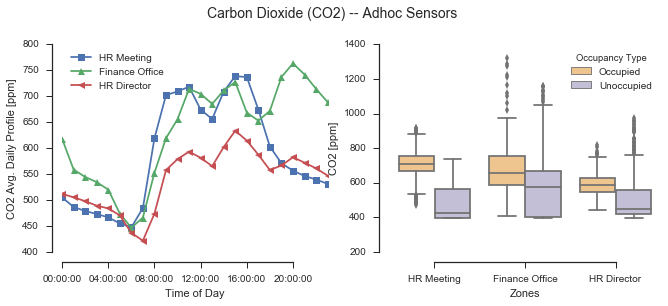

In [656]:
co2_pivot = pivot_day_3(co2_part, ['Photon_1','Photon_3','Photon_5'], '2017-02-20','2017-03-02', particle_name_mapping)
co2, co2_occupied, co2_unoccupied = get_occ_and_unoocdata(co2_part, ['Photon_2','Photon_4'], '2017-02-20','2017-03-02')
plot_values_all(co2_occupied, co2_unoccupied, co2_pivot,"CO2 Avg. Daily Profile [ppm]","Time of Day","CO2 [ppm]","Carbon Dioxide (CO2) -- Adhoc Sensors", particle_name_mapping, "PuOr")

## BMS CO2

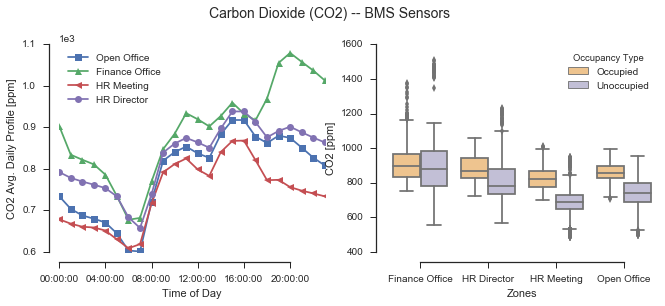

In [657]:
co2_grouped = all_data_co2_febmar.groupby(level='Location', axis=1).mean()
co2_pivot = pivot_day(co2_grouped, ['OpenOffice','FinanceOffice3','HRMeeting','HRDirector'], '2017-02-20','2017-03-02', name_mapping)
co2, co2_occupied, co2_unoccupied = get_occ_and_unoocdata(co2_grouped, [u'BoardRoom',u'FinanceOffice1',
 u'FinanceOffice2',
 #u'FinanceOffice3',
 u'FinanceSecretary',
 #u'HRDirector',
 #u'HRMeeting',
 u'HROffice1',
 u'HROffice2',
 u'HeadofSchool',
 u'HeadofSchoolSecretary',
 u'Pantry',"Block10","Block3", u'DOAS1', u'DOAS2', u'DOAS3',
       u'DOAS4', u'FCU1', u'FCU2', u'FCU3', u'FCU4',]
                                                            , '2017-02-20','2017-03-02')
plot_values_all(co2_occupied, co2_unoccupied, co2_pivot,"CO2 Avg. Daily Profile [ppm]","Time of Day","CO2 [ppm]","Carbon Dioxide (CO2) -- BMS Sensors", name_mapping, "PuOr")

## VOC 

In [658]:
voc_part = data['VOC'].truncate(before='2017-02-20')

In [659]:
all_data_voc_febmar.head()

sensorbank,VOC2,VOC3
2017-02-20 00:00:00+08:00,NaN,NaN
2017-02-20 00:10:00+08:00,NaN,NaN
2017-02-20 00:20:00+08:00,NaN,NaN
2017-02-20 00:30:00+08:00,NaN,NaN
2017-02-20 00:40:00+08:00,NaN,NaN


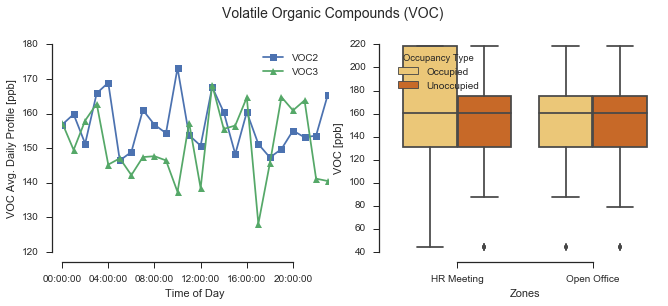

In [660]:
voc_pivot = pivot_day_2(all_data_voc_febmar, ['VOC2','VOC3'], '2017-02-20','2017-02-25', particle_name_mapping)
voc, voc_occupied, voc_unoccupied = get_occ_and_unoocdata(all_data_voc_febmar, 'none', '2017-02-20','2017-02-25')
plot_values_all(voc_occupied, voc_unoccupied, voc_pivot,"VOC Avg. Daily Profile [ppb]","Time of Day","VOC [ppb]","Volatile Organic Compounds (VOC)", voc_name_mapping, "YlOrBr")

# Operative Temperature

In [661]:
#data

In [662]:
optemp_part = data['Ball-Temp'].truncate(before='2017-02-20')

In [663]:
optemp_part.head()

sensorbank,Photon_1,Photon_2,Photon_3,Photon_4,Photon_5,TTest3
2017-02-20 00:00:00+08:00,27.646963,NaN,25.926604,25.814451,26.076143,NaN
2017-02-20 00:10:00+08:00,27.618703,NaN,25.948635,25.795758,26.106407,NaN
2017-02-20 00:20:00+08:00,27.618258,NaN,25.963099,25.801098,26.108187,NaN
2017-02-20 00:30:00+08:00,27.609802,NaN,25.963989,25.796647,26.154472,NaN
2017-02-20 00:40:00+08:00,27.614252,NaN,25.941291,25.787746,26.118200,NaN


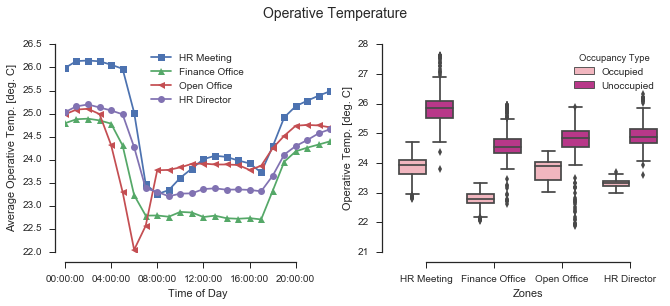

In [670]:
optemp_pivot = pivot_day(optemp_part, ['Photon_1','Photon_3','Photon_4','Photon_5'], '2017-02-20','2017-03-02', particle_name_mapping)
optemp, optemp_occupied, optemp_unoccupied = get_occ_and_unoocdata(optemp_part, ['Photon_2','TTest3'], '2017-02-20','2017-03-02')
plot_values_all(optemp_occupied, optemp_unoccupied, optemp_pivot,"Average Operative Temp. [deg. C]","Time of Day","Operative Temp. [deg. C]","Operative Temperature", particle_name_mapping, "RdPu")

## Particles

In [665]:
data['dustDensity'].head()#.plot()

sensorbank,Photon_1,Photon_2,Photon_3,Photon_4,Photon_5
2016-08-02 10:20:00+08:00,0.0,NaN,NaN,0.000000,0.0
2016-08-02 10:30:00+08:00,0.0,NaN,NaN,0.000000,0.0
2016-08-02 10:40:00+08:00,0.0,NaN,NaN,0.000000,0.0
2016-08-02 10:50:00+08:00,0.0,NaN,NaN,0.000000,0.0
2016-08-02 11:00:00+08:00,0.0,NaN,NaN,-159.904297,0.0


In [666]:
dust = data['dustDensity'].truncate(before='2017-02-20')

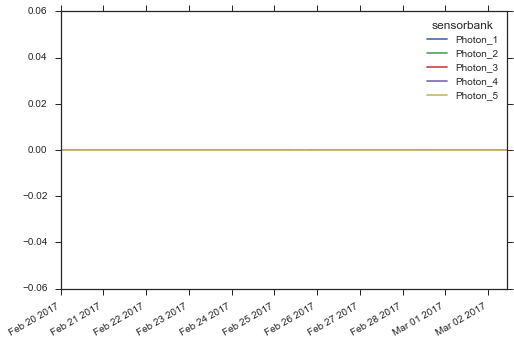

In [667]:
dust[dust>=0].plot()

In [669]:
# optemp_pivot = pivot_day(dust, ['Photon_1','Photon_3','Photon_4','Photon_5'], '2017-02-20','2017-03-02', particle_name_mapping)
# optemp, optemp_occupied, optemp_unoccupied = get_occ_and_unoocdata(optemp_part, ['Photon_2','TTest3'], '2017-02-20','2017-03-02')
# plot_values_all(optemp_occupied, optemp_unoccupied, optemp_pivot,"Average Operative Temp. [deg. C]","Time of Day","Operative Temp. [deg. C]","Operative Temperature", particle_name_mapping, "RdPu")